### Import Libraries

In [1]:
import os
import cv2
import copy
import math
import time
import tarfile
import numbers
import threading
import queue as Queue
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from torchvision.datasets.utils import download_url
#from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split, DataLoader, Dataset
from torchsummary import summary

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
random_seed = 42
torch.manual_seed(random_seed);

In [4]:
torch.set_printoptions(edgeitems=5)

In [5]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [6]:
device = get_default_device()

In [7]:
device

device(type='cuda')

In [ ]:
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split

In [ ]:
lfw_people = fetch_lfw_people(data_home = "../datasets/", color=True) #D:/Face/send/

In [ ]:
X = lfw_people.data
y = lfw_people.target

In [ ]:
X = X.reshape(13233, 62, 47, 3)

In [ ]:
new_X = np.empty((13233,62, 47, 3), int)
new_X.shape

In [ ]:
for x_img in X:
    #print(x_img.shape)
    x_img = center_transformations(x_img.astype(np.uint8))
    #x_img.shape
    np.append(new_X, x_img)

In [ ]:
new_X

In [ ]:
X = np.transpose(new_X, (0, 3, 1, 2))

In [ ]:
X = np.transpose(X, (0, 3, 1, 2))

In [ ]:
imgs = torch.from_numpy(X)
labels = torch.from_numpy(y)
imgs.shape, labels.shape

In [ ]:
tra = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])

In [ ]:
center_transformations = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])

In [ ]:
imgs

In [ ]:
imgs = tra(imgs)
imgs.shape

In [ ]:
imgs

In [ ]:
data = zip(imgs, labels)

In [ ]:
lfw_list = []
for a, b in data:
    lfw_list.append([a, b])

In [ ]:
img, label = lfw_list[1500]
img = img.permute(1, 2, 0)
#img = torch.reshape(img, (62, 47, 3))
#print(img)
img = img.int()

plt.imshow(img)
plt.title('label = ' + str(label))

In [ ]:
img, label = lfw_list[1500]

img = img.numpy() #Convert the tensor input into a numpy object
img = img.astype(int)

img = np.transpose(img, (1, 2, 0)) #Shifting the channel into the 3rd dimension       

plt.imshow(img)
plt.title('label = ' + str(label.item()))

In [ ]:
len(lfw_list), lfw_list[0][0].shape

In [ ]:
test_factor = 0.15
test_size = int(test_factor * len(lfw_list))
train_size = len(lfw_list) - test_size
train_ds, test_ds = random_split(lfw_list, [train_size, test_size])

val_factor = 0.15
val_size = int(val_factor * len(lfw_list))
train_size = len(train_ds) - val_size
train_ds, val_ds = random_split(train_ds, [train_size, val_size])

In [ ]:
len(train_ds), len(val_ds), len(test_ds)

### Step 1a) Fetch the LFW dataset

In [8]:
main_dir = '../datasets/LFW' #For Ubuntu
#main_dir = 'D:/Face/LFW' #For Windows
data_dir = main_dir + "/lfw-deepfunneled/lfw-deepfunneled"

print(os.listdir(main_dir))
classes = os.listdir(data_dir)
print(len(classes))

['people.csv', 'lfw_readme.csv', 'pairs.csv', 'matchpairsDevTest.csv', 'lfw-deepfunneled', 'peopleDevTest.csv', 'matchpairsDevTrain.csv', 'peopleDevTrain.csv', 'mismatchpairsDevTrain.csv', 'mismatchpairsDevTest.csv', 'lfw_allnames.csv']
5749


In [9]:
img_Aaron_Eckhart = os.listdir(data_dir + "/Aaron_Eckhart")
print('No. of training examples for Aaron_Eckhart:', len(img_Aaron_Eckhart))
print(img_Aaron_Eckhart[:])

No. of training examples for Aaron_Eckhart: 1
['Aaron_Eckhart_0001.jpg']


In [10]:
# size1 = 250
# dataset1 = ImageFolder(data_dir, transform=ToTensor())

In [11]:
size2 = 112 #250
center_transformations = transforms.Compose(
    [
        transforms.CenterCrop(size2),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])

dataset2 = ImageFolder(data_dir, transform=center_transformations)

In [12]:
len(dataset2)

13233

In [13]:
print(dataset2.classes)

['AJ_Cook', 'AJ_Lamas', 'Aaron_Eckhart', 'Aaron_Guiel', 'Aaron_Patterson', 'Aaron_Peirsol', 'Aaron_Pena', 'Aaron_Sorkin', 'Aaron_Tippin', 'Abba_Eban', 'Abbas_Kiarostami', 'Abdel_Aziz_Al-Hakim', 'Abdel_Madi_Shabneh', 'Abdel_Nasser_Assidi', 'Abdoulaye_Wade', 'Abdul_Majeed_Shobokshi', 'Abdul_Rahman', 'Abdulaziz_Kamilov', 'Abdullah', 'Abdullah_Ahmad_Badawi', 'Abdullah_Gul', 'Abdullah_Nasseef', 'Abdullah_al-Attiyah', 'Abdullatif_Sener', 'Abel_Aguilar', 'Abel_Pacheco', 'Abid_Hamid_Mahmud_Al-Tikriti', 'Abner_Martinez', 'Abraham_Foxman', 'Aby_Har-Even', 'Adam_Ant', 'Adam_Freier', 'Adam_Herbert', 'Adam_Kennedy', 'Adam_Mair', 'Adam_Rich', 'Adam_Sandler', 'Adam_Scott', 'Adel_Al-Jubeir', 'Adelina_Avila', 'Adisai_Bodharamik', 'Adolfo_Aguilar_Zinser', 'Adolfo_Rodriguez_Saa', 'Adoor_Gopalakarishnan', 'Adrian_Annus', 'Adrian_Fernandez', 'Adrian_McPherson', 'Adrian_Murrell', 'Adrian_Nastase', 'Adriana_Lima', 'Adriana_Perez_Navarro', 'Adrianna_Zuzic', 'Adrien_Brody', 'Afton_Smith', 'Agbani_Darego', 'Agn

### Step 1b) Visualize the dataset

In [14]:
# img, label = dataset1[1500]
# print(img.shape, label)

In [15]:
# img, label = dataset1[1500]
# img = torch.reshape(img, (size1, size1, 3))

# plt.imshow(img)
# plt.title('label = ' + str(label))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'label = 667')

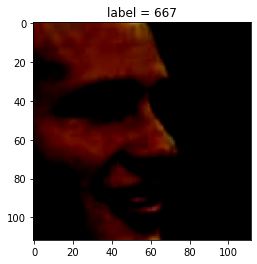

In [16]:
img, label = dataset2[1500]
#img = torch.reshape(img, (size2, size2, 3))
img = img.permute(1, 2, 0)

plt.imshow(img)
plt.title('label = ' + str(label))

In [17]:
# img, label = dataset1[0]
# img = torch.reshape(img, (size1, size1, 3))

# plt.imshow(img)
# plt.title('label = ' + str(label))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'label = 0')

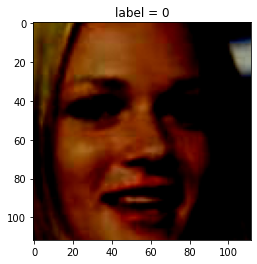

In [18]:
img, label = dataset2[0]
#img = torch.reshape(img, (size2, size2, 3))
img = img.permute(1, 2, 0)

plt.imshow(img)
plt.title('label = ' + str(label))

### Step 1c) Split the dataset into training, validation, and testing

In [19]:
test_factor = 0.10
test_size = int(test_factor * len(dataset2))
train_size = len(dataset2) - test_size
train_ds, test_ds = random_split(dataset2, [train_size, test_size])

val_factor = 0.1
val_size = int(val_factor * len(dataset2))
train_size = len(train_ds) - val_size
train_ds, val_ds = random_split(train_ds, [train_size, val_size])

In [20]:
len(train_ds), len(val_ds), len(test_ds)

(10587, 1323, 1323)

In [21]:
batch_size=128

In [22]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

In [23]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [24]:
len(train_dl), len(val_dl), len(test_dl)

(83, 11, 11)

### Step 2a) Model Architecture - Network

In [25]:
def conv_2d(ni, nf, ks, stride=1):
    return nn.Conv2d(in_channels=ni, out_channels=nf, kernel_size=ks, stride=stride, padding=ks//2, bias=False)

def bn_relu_conv(ni, nf, ks):
    return nn.Sequential(nn.BatchNorm2d(ni), 
                       nn.ReLU(inplace=True),
                       conv_2d(ni, nf, ks))

In [26]:
class ResBlock(nn.Module):
    def __init__(self, ni, nf, stride=1):
        super().__init__()
        if ni > 100:
            temp = ni * 2
        else:
            temp = ni
        self.bn = nn.BatchNorm2d(temp)
        self.conv1 = conv_2d(temp, ni, 1, stride)
        self.conv2 = bn_relu_conv(ni, ni, ks=3)
        self.conv3 = bn_relu_conv(ni, nf, ks=1)
        self.shortcut = lambda x: x
        if ni != nf:
            self.shortcut = conv_2d(temp, nf, 1, stride)

    def forward(self, x):
        #print("Inside Res Block1")
        #print(x.shape)
        x = F.relu(self.bn(x), inplace=True)
        #print(x.shape)
        r1 = self.shortcut(x)
        #print(r1.shape)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x) * 0.2
        #print(x.shape)
        return x.add_(r1)

In [27]:
class ResBlock2(nn.Module):
    def __init__(self, ni, nf, stride=1):
        super().__init__()
        self.bn = nn.BatchNorm2d(ni)
        self.conv1 = conv_2d(ni, nf, 1, stride)
        self.conv2 = bn_relu_conv(nf, nf, ks=3)
        self.conv3 = bn_relu_conv(nf, ni, ks=1)
        self.shortcut = lambda x: x
#        if ni != nf:
#            self.shortcut = conv_2d(ni, nf, 1, 1)

    def forward(self, x):
        #print("Inside Res Block2")
        #print(x.shape)
        x = F.relu(self.bn(x), inplace=True)
        #print(x.shape)
        r = self.shortcut(x)
        #print(r.shape)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x) * 0.2
        return x.add_(r)

In [28]:
def make_group(N, ni, nf, stride):
    start = ResBlock(ni, nf, stride)
    rest = [ResBlock2(nf, ni) for j in range(1, N)]
    return [start] + rest

In [29]:
class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return x.view(x.size(0), -1)

In [30]:
class MyResNet(nn.Module):
    def __init__(self, n_groups, N, n_classes, k=1, n_start=64):
        super().__init__()
        #Increase channels
        self.layers = [conv_2d(3, 64, ks=7, stride=2)]
        self.layers += [nn.MaxPool2d(kernel_size=3, stride=2, padding=1)]
        n_channels = [n_start]

        #Add groups
        for i in range(n_groups):
            n_channels.append(n_start*(2**i)*k)
            stride = 2 if i>0 else 1
            self.layers += make_group(N[i], n_channels[i], n_channels[i]*4, stride)

        #Pool, Flatten, and add linear layer for classification  
        self.layers += [nn.BatchNorm2d(n_channels[n_groups]*2),
                   nn.ReLU(inplace=True),
                   nn.AdaptiveAvgPool2d(1),
                   #nn.AvgPool2d(kernel_size=2, stride=2), 
                   Flatten()]
        #self.fc = nn.Linear(n_channels[n_groups]*2, n_classes)
    
        self.features = nn.Sequential(*self.layers)
        
    def forward(self, x):
        #a = self.features(x)
        #print(a.shape)
        temp = self.features(x)
        return temp #self.fc(temp)

In [31]:
#Number of blocks at various groups
N_50 = [3, 4, 6, 3]
N_101 = [3, 4, 23, 3]
N_152 = [3, 8, 36, 3]

def ResNet50(n_classes):
    return MyResNet(4, N_50, n_classes, k=2)

def ResNet101(n_classes):
    return MyResNet(4, N_101, n_classes, k=2)

def ResNet152(n_classes):
    return MyResNet(4, N_152, n_classes, k=2)

In [32]:
loaded_model = ResNet50(85742)
to_device(loaded_model, device)

MyResNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (2): ResBlock(
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (conv3): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (shortcut): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (3): ResBlock2(
      (bn): 

In [37]:
checkpoint = torch.load("Checkpoints/model_01_Mar_11.pt")
loaded_model.load_state_dict(checkpoint['model_state_dict'])
#opt1 = checkpoint['model_optimizer_state_dict']
#opt2 = checkpoint['fc_optimizer_state_dict']
#opt2['state'][0]['momentum_buffer']
#n.kernel.shape
train_acc = checkpoint['train_acc']
val_acc = checkpoint['val_acc']
print(train_acc, val_acc)

0.6999151804278246 0.5830163241822881


In [ ]:
#loaded_model.load_state_dict(torch.load("training/el_2epoch_70acc.pth"))
loaded_model.load_state_dict(torch.load("training/el_22epoch_95acc_cosface.pth"))

In [38]:
summary(loaded_model, input_size = (3, 62, 47), batch_size = -1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 31, 24]           9,408
         MaxPool2d-2           [-1, 64, 16, 12]               0
       BatchNorm2d-3           [-1, 64, 16, 12]             128
            Conv2d-4          [-1, 256, 16, 12]          16,384
            Conv2d-5           [-1, 64, 16, 12]           4,096
       BatchNorm2d-6           [-1, 64, 16, 12]             128
              ReLU-7           [-1, 64, 16, 12]               0
            Conv2d-8           [-1, 64, 16, 12]          36,864
       BatchNorm2d-9           [-1, 64, 16, 12]             128
             ReLU-10           [-1, 64, 16, 12]               0
           Conv2d-11          [-1, 256, 16, 12]          16,384
         ResBlock-12          [-1, 256, 16, 12]               0
      BatchNorm2d-13          [-1, 256, 16, 12]             512
           Conv2d-14           [-1, 64,

In [ ]:
#model.layers

In [ ]:
# #model = ResNet50(85742)

# for param in loaded_model.parameters():
#     param.requires_grad = False
#     #print(param.shape)
#     #print('----------------------------')
#     #model.fc = nn.Linear(5749, 8)
#     #print("After addition: ", param.shape)

In [39]:
to_device(loaded_model, device)

MyResNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (2): ResBlock(
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (conv3): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (shortcut): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (3): ResBlock2(
      (bn): 

In [ ]:
summary(loaded_model, input_size = (3, 250, 250), batch_size = -1)

### Step 2b) Loss Function

In [40]:
class CosFace(nn.Module):
    def __init__(self, in_features=2048, out_features=5749, s=64.0, m=0.35):
        super(CosFace, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.kernel = nn.Parameter(torch.FloatTensor(in_features, out_features))
        nn.init.normal_(self.kernel, std=0.01)

    def forward(self, logits, labels):
        logits = F.normalize(logits, p=2.0, dim=1) #l2_norm(logits, axis=1)
        kernel_norm = F.normalize(self.kernel, p=2.0, dim=0) #l2_norm(self.kernel, axis=0)
        cos_theta = torch.mm(logits, kernel_norm)
        cos_theta = cos_theta.clamp(-1, 1)  # for numerical stability
        index = torch.where(labels != -1)[0]
        m_hot = torch.zeros(index.size()[0], cos_theta.size()[1]).to(device)
        m_hot.scatter_(1, labels[index, None], self.m).to(device)
        cos_theta[index] -= m_hot
        ret = cos_theta * self.s
        return ret

In [41]:
new_logits = CosFace()

In [42]:
to_device(new_logits, device)
#new_logits.to(device)

CosFace()

In [43]:
loss_Function = nn.CrossEntropyLoss() #F.cross_entropy

### Step 3) Training the model

In [44]:
def loss_batch(model, loss_func, xb, yb, opt=None, opt_out=None, metric=None):
    #Generate predictions
    features = F.normalize(model(xb))
    preds = new_logits(features, yb)
    
    #Generate probabilities
    #preds = F.softmax(preds, dim=1)
    
    #Calculate loss
    loss = loss_func(preds, yb)
    
    if opt is not None:
        #Compute gradients
        loss.backward()
        
        #Gradient Clipping
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=5, norm_type=2)
        
        #update parameters
        opt.step()
        opt_out.step()
        
        #Reset Gradients
        opt.zero_grad()
        opt_out.zero_grad()

    metric_result = None
    if metric is not None:
        #compute the metric
        metric_result = metric(preds, yb)
    
    #print(loss.is_cuda)
    #print(xb.is_cuda)
    #print(metric_result.is_cuda)
        
    return loss.item(), len(xb), metric_result

In [45]:
def evaluate(model, loss_fn, valid_dl, metric=None):
    with torch.no_grad():
        #pass each batch through the model
        results = [loss_batch(model, loss_fn, xb, yb, metric=metric) for xb, yb in valid_dl]
        #separate losses, counts and metrics
        losses, nums, metrics = zip(*results)
        #Total size of the dataset
        total = np.sum(nums)
        #Avg. loss across batches
        avg_loss = np.sum(np.multiply(losses, nums))/total
        avg_metric = None
        
        if metric is not None:
            #Avg of metric across batches
            avg_metric = np.sum(np.multiply(metrics, nums)) / total

    return avg_loss, total, avg_metric

In [46]:
def fit(epochs, model, loss_fn, train_dl, valid_dl, lr=None, lr_func=None, metric=None, opt_fn=None):
    
    train_losses, train_metrics, val_losses, val_metrics = [], [], [], []
    
    #instantiate the optimizer
    if opt_fn is None: opt_fn = torch.optim.SGD
    opt = opt_fn(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-6)
    opt_out = opt_fn(new_logits.parameters(), lr=lr, momentum=0.9, weight_decay=5e-6)
    
    scheduler_network = torch.optim.lr_scheduler.LambdaLR(optimizer=opt, lr_lambda=lr_func)
    scheduler_out = torch.optim.lr_scheduler.LambdaLR(optimizer=opt_out, lr_lambda=lr_func)
    
    for epoch in range(epochs):
        start = time.time()
        ep_train_losses, train_len, ep_train_metrics = [], [], []
        
        #Training
        model.train()
        for xb, yb in train_dl:
            train_loss, len_xb, train_metric = loss_batch(model, loss_fn, xb, yb, 
                                                          opt, opt_out, metric)
            ep_train_losses.append(train_loss)
            train_len.append(len_xb)
            ep_train_metrics.append(train_metric)
            
        scheduler_network.step()
        scheduler_out.step()
        
        total = np.sum(train_len)
        avg_train_loss = np.sum(np.multiply(ep_train_losses, train_len)) / total
        avg_train_metric = None
        if metric is not None:
            avg_train_metric = np.sum(np.multiply(ep_train_metrics, train_len)) / total

        #Evaluation
        model.eval()
        result = evaluate(model, loss_fn, valid_dl, metric)
        val_loss, total, val_metric = result

        #Record the loss and metric
        train_losses.append(avg_train_loss)
        train_metrics.append(avg_train_metric)
        val_losses.append(val_loss)
        val_metrics.append(val_metric)
        
#         #Checkpointing the model - saving every 'n' epochs
#         checkpoint_path = "Checkpoints/lfw_finetune_model_01_" +str(epoch)+".pt"
        
#         if (epoch%10 == 0):
#             torch.save({
#                 'epoch': epoch,
#                 'model_state_dict': model.state_dict(),
#                 #'model_optimizer_state_dict': opt.state_dict(),
#                 #'fc_optimizer_state_dict': opt_out.state_dict(),
#                 'new_logits': new_logits,
#                 'train_acc': avg_train_metric,
#                 'val_acc': val_metric,
#             }, checkpoint_path)
        
        end = time.time()

        #Print progress:
        if metric is None:
            print('Epoch [{}/{}], Train_loss: {:.4f}, Val_loss: {:.4f}'
                  .format(epoch+1, epochs, train_loss, val_loss))
            print(str(round((end - start), 2)) + " secs")
        
        else:
            print('Epoch [{}/{}], Train_loss: {:.4f}, Val_loss: {:.4f}, Train_{}: {:.4f}, Val_{}: {:.4f}'
                  .format(epoch+1, epochs, avg_train_loss, val_loss, metric.__name__,  avg_train_metric, 
                          metric.__name__, val_metric))
            print(str(round((end - start), 2)) + " secs")

    return train_losses, train_metrics, val_losses, val_metrics

In [47]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.sum(preds == labels).item() / len(preds)

In [48]:
val_loss, _, val_acc = evaluate(loaded_model, loss_Function, val_dl, metric=accuracy) #metric=accuracy #metric=None

In [49]:
#print('Loss: {:.4f}'.format(val_loss))
print('Loss: {:.4f}, Accuracy: {:.4f}'.format(val_loss, val_acc))

Loss: 32.0651, Accuracy: 0.0000


In [50]:
opt_func = torch.optim.SGD

In [51]:
def lr_step_func(epoch):
    return ((epoch + 1) / (4 + 1)) ** 2 if epoch < -1 else 0.1 ** len(
        [m for m in [11,21,31,41] if m-1 <= epoch])

In [52]:
#No dynamic updation in LR
def unit_lr(epoch):
    return 1

In [72]:
num_epochs = 50
lr = 0.00001

In [73]:
history = fit(epochs=num_epochs, model=loaded_model, loss_fn=loss_Function, 
              train_dl=train_dl, valid_dl=val_dl, lr=lr, lr_func=unit_lr, #lr_step_func, #
              metric=accuracy, opt_fn=opt_func)

Epoch [1/50], Train_loss: 0.0070, Val_loss: 22.4297, Train_accuracy: 0.9998, Val_accuracy: 0.2320
18.98 secs
Epoch [2/50], Train_loss: 0.0075, Val_loss: 22.2691, Train_accuracy: 0.9997, Val_accuracy: 0.2358
19.25 secs
Epoch [3/50], Train_loss: 0.0057, Val_loss: 22.1494, Train_accuracy: 0.9996, Val_accuracy: 0.2389
19.2 secs
Epoch [4/50], Train_loss: 0.0065, Val_loss: 22.5703, Train_accuracy: 0.9996, Val_accuracy: 0.2283
19.14 secs
Epoch [5/50], Train_loss: 0.0073, Val_loss: 22.4813, Train_accuracy: 0.9997, Val_accuracy: 0.2283
19.19 secs
Epoch [6/50], Train_loss: 0.0080, Val_loss: 22.3801, Train_accuracy: 0.9997, Val_accuracy: 0.2366
19.23 secs
Epoch [7/50], Train_loss: 0.0072, Val_loss: 22.5087, Train_accuracy: 0.9997, Val_accuracy: 0.2275
19.26 secs
Epoch [8/50], Train_loss: 0.0059, Val_loss: 22.3521, Train_accuracy: 0.9997, Val_accuracy: 0.2252
18.68 secs
Epoch [9/50], Train_loss: 0.0058, Val_loss: 22.4003, Train_accuracy: 0.9998, Val_accuracy: 0.2290
17.85 secs
Epoch [10/50], Train

In [74]:
train_losses, train_metrics, val_losses, val_metrics = history

In [76]:
# Creating a new data frame
newDataframe = pd.DataFrame()
filename = "lfw_model_outputs.xlsx"
sheet_name = "Sheet FT CosFacev2 02Mar_5"

newDataframe['Train Loss'] = train_losses
newDataframe['Val Loss'] = val_losses
newDataframe['Train Acc.'] = train_metrics
newDataframe['Val Acc.'] = val_metrics

# Converting the data frame to an excel file
# newDataframe.to_excel('lfw_model_outputs.xlsx', sheet_name="Sheet 2", index = False)

with pd.ExcelWriter(filename, mode="a", engine="openpyxl") as writer:
    newDataframe.to_excel(writer, sheet_name=sheet_name)

# Reading the data from the outputExcelFile
excelData = pd.read_excel(filename, sheet_name=sheet_name)

#Printing the data frame
print(excelData)

    Unnamed: 0  Train Loss   Val Loss  Train Acc.  Val Acc.
0            0    0.007028  22.429725    0.999811  0.232048
1            1    0.007470  22.269148    0.999717  0.235828
2            2    0.005655  22.149401    0.999622  0.238851
3            3    0.006451  22.570274    0.999622  0.228269
4            4    0.007344  22.481265    0.999717  0.228269
5            5    0.007972  22.380128    0.999717  0.236584
6            6    0.007205  22.508662    0.999717  0.227513
7            7    0.005946  22.352057    0.999717  0.225246
8            8    0.005838  22.400298    0.999811  0.229025
9            9    0.007742  22.378223    0.999717  0.242630
10          10    0.006663  22.429396    0.999717  0.236584
11          11    0.006987  22.474410    0.999622  0.227513
12          12    0.006978  22.622817    0.999717  0.229781
13          13    0.006879  22.370723    0.999717  0.241119
14          14    0.006538  22.346759    0.999622  0.232048
15          15    0.007282  22.326882   

### Step 4) Evaluate the model and Plotting of curves

In [77]:
def plot_accuracies(epoch, train_metrics, val_metrics):
    #accuracies = [x['val_metrics'] for x in history]
    x = np.arange(1, epoch+1, 1)
    plt.plot(x, train_metrics, '-bx')
    plt.plot(x, val_metrics, '-rx')
    
    plt.tick_params(labelcolor='g')
    plt.xticks(np.linspace(1, epoch, int(epoch/5)))
    
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs')

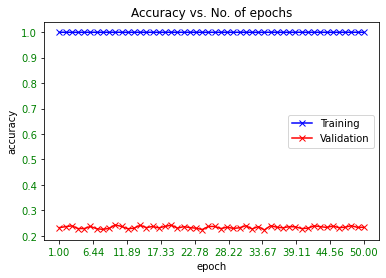

In [78]:
plot_accuracies(num_epochs, train_metrics, val_metrics)

In [79]:
def plot_losses(epoch, train_losses, val_losses):
    #train_losses = [x.get('train_losses') for x in history]
    #val_losses = [x['val_losses'] for x in history]
    x = np.arange(1, epoch+1, 1)
    
    plt.plot(x, train_losses, '-bx')
    plt.plot(x, val_losses, '-rx')
    
    plt.tick_params(labelcolor='g')
    plt.xticks(np.linspace(1, epoch, 5))
    
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

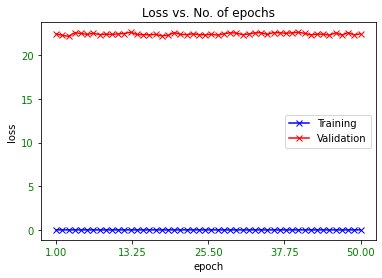

In [80]:
plot_losses(num_epochs, train_losses, val_losses)

In [81]:
result = evaluate(loaded_model, loss_Function, test_dl, accuracy)
result

(21.88351585030646, 1323, 0.25170068027210885)

In [ ]:
torch.save(loaded_model.state_dict(), 'el_lfw_fineTune_cosface_01Mar.pth')

In [ ]:
torch.save(new_logits, 'kernel_weights_lfw_fineTune_cosface_01Mar.pt')

In [ ]:
def prepare_plot(image, origTarget, predTarget, size=5):
    plt.rcParams["figure.figsize"] = (15*size/25, 15*size/5)
    rand = np.random.randint(0, 128, size)
    
    for i in range(size):
        plt.subplot(size, 3, 3*i+1)
        plt.imshow(image[rand[i]])
        plt.axis('off')
        
        plt.subplot(size, 3, 3*i+2)
        plt.axis('off')
        plt.title('Actual id: ' + str(origTarget[rand[i]]) + '\n Predicted id: ' + str(predTarget[rand[i]]))
        
        plt.subplot(size, 3, 3*i+3)
        plt.axis('off')
        if(origTarget[rand[i]] == predTarget[rand[i]]):
            plt.title('\n\n MATCHED!', fontsize = 12, color='g')
        else:
            plt.title('\n\n MIS-MATCHED!', fontsize = 15, color='r')
    
    plt.show()

In [ ]:
def make_predictions(model, dataLoader, size):
    with torch.no_grad():
        #set the model in evaluation mode
        model.eval()
        
        for xb, yb in dataLoader:
            features = F.normalize(model(xb))
            pred = new_logits(features, yb)
            
            softmax = F.softmax(pred, dim=1)
            #print(softmax)
            sum_check = torch.sum(softmax, dim=1)
            #print(sum_check)
            max_value = torch.max(softmax, dim=1)[1]
            #print("Predicted labels: ", max_value)
            #print("Actual labels: ", yb)
            
            matches = max_value == yb
            #print(matches)

            invTransform = transforms.Compose(
                [transforms.Normalize(mean=[0., 0., 0.], std=[1/0.5, 1/0.5, 1/0.5]),
                 transforms.Normalize(mean=[-0.5, -0.5, -0.5], std=[1, 1, 1]),
                ])
            xb = invTransform(xb)
    
            xb = xb.cpu().numpy() #Convert the tensor input into a numpy object
            #print(xb.shape)

            xb = np.transpose(xb, (0, 2, 3, 1)) #Shifting the channel into the 3rd dimension       
            print(xb.shape)

            yb = yb.cpu().numpy() #Convert the tensor input into a numpy object
            #print(yb[0])

            max_value = max_value.cpu().numpy() #Convert the tensor input into a numpy object
            #print(max_value[0])

            prepare_plot(xb, yb, max_value, size)
            
            break

In [ ]:
make_predictions(loaded_model, val_dl, 10)

In [ ]:
# def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
#     since = time.time()

#     best_model_wts = copy.deepcopy(model.state_dict())
#     best_acc = 0.0

#     for epoch in range(num_epochs):
#         print(f'Epoch {epoch}/{num_epochs - 1}')
#         print('-' * 10)

#         # Each epoch has a training and validation phase
#         for phase in ['train', 'val']:
#             if phase == 'train':
#                 model.train()  # Set model to training mode
#                 dataloader = train_dl
#             else:
#                 model.eval()   # Set model to evaluate mode
#                 dataloader = val_dl

#             len_input = 0
#             running_loss = 0.0
#             running_corrects = 0

#             # Iterate over data.
#             for inputs, labels in dataloader:
#                 # zero the parameter gradients
#                 optimizer.zero_grad()

#                 # forward
#                 # track history if only in train
#                 with torch.set_grad_enabled(phase == 'train'):
#                     outputs = model(inputs)
#                     _, preds = torch.max(outputs, 1)
#                     loss = criterion(outputs, labels)

#                     # backward + optimize only if in training phase
#                     if phase == 'train':
#                         loss.backward()
#                         optimizer.step()

#                 # statistics
#                 len_input += len(inputs)
#                 running_loss += loss.item() * len(inputs)
#                 running_corrects += torch.sum(preds == labels).item() / len(preds)
#             if phase == 'train':
#                 scheduler.step()

#             epoch_loss = running_loss / len_input
#             epoch_acc = running_corrects / len_input

#             print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

#             # deep copy the model
#             if phase == 'val' and epoch_acc > best_acc:
#                 best_acc = epoch_acc
#                 best_model_wts = copy.deepcopy(model.state_dict())

#         print()

#     time_elapsed = time.time() - since
#     print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
#     print(f'Best val Acc: {best_acc:4f}')

#     # load best model weights
#     model.load_state_dict(best_model_wts)
#     return model

In [ ]:
# criterion = F.cross_entropy

# # Observe that all parameters are being optimized
# optimizer_ft = torch.optim.SGD(loaded_model.parameters(), lr=0.001, momentum=0.9)

# # Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
# model_ft = train_model(loaded_model, criterion, optimizer_ft, exp_lr_scheduler,
#                        num_epochs=10)